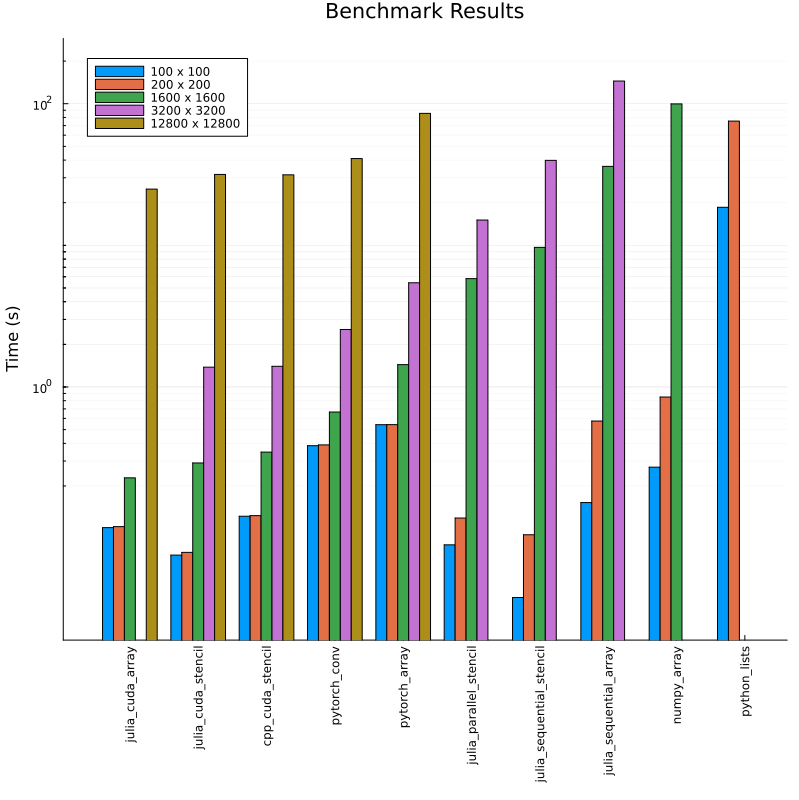

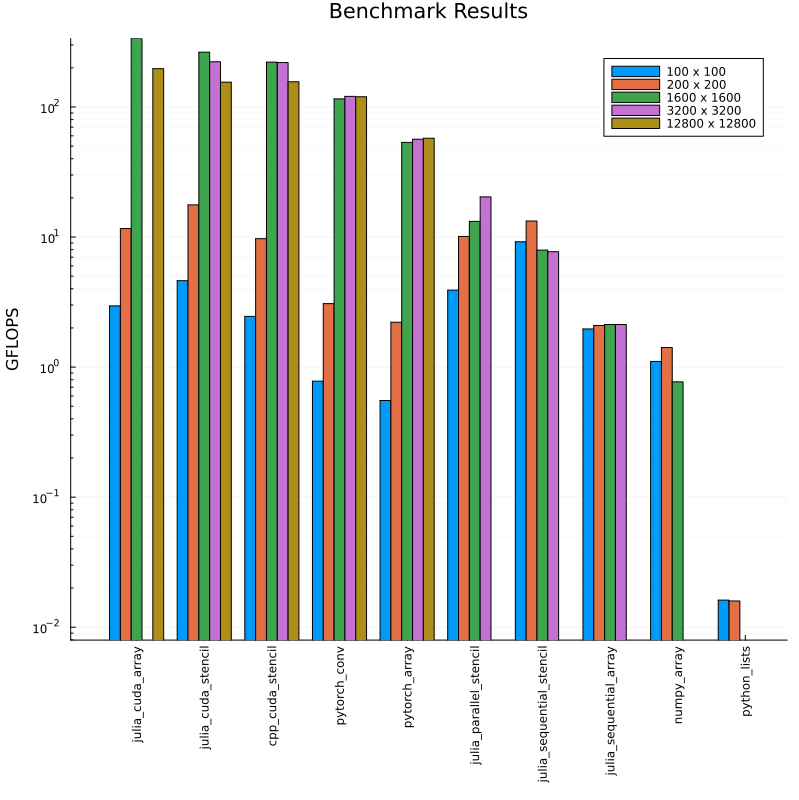

In [14]:
using Plots
using StatsPlots
using YAML
using Statistics
benchmarks = YAML.load_file("benchmark_results.yaml")
benchmark_names = sort(collect(keys(benchmarks)), by= x->parse(Int, first(split(x, "."))))
benchmark_names = benchmark_names[[1,2,5,6,8]]
benchmark_numbers = [parse(Int, first(split(b, "."))) for b in benchmark_names]
num_setups = length(benchmark_names)
implementation_names = collect(keys(benchmarks[first(benchmark_names)]))
max_time_by_implementation = [median([haskey(benchmarks[b],i) ? benchmarks[b][i]["time"]["median"] : Inf for b in benchmark_names]) for i in implementation_names]
sort_permutation = sortperm(max_time_by_implementation)
implementation_names = collect(implementation_names[sort_permutation])
num_implementations = length(implementation_names)
medians = zeros(num_implementations, num_setups)
flops= zeros(num_implementations, num_setups)

num_iterations = 5000
num_computations_per_grid_point = 6
num_gridpoints= benchmark_numbers.^2
num_computations= num_computations_per_grid_point*num_gridpoints * num_iterations

for (i, benchmark_name) in enumerate(benchmark_names)
    benchmark = benchmarks[benchmark_name]
    for (j, implementation_name) in enumerate(implementation_names)
        if !haskey(benchmark, implementation_name)
            medians[j, i] = Inf
            flops[j, i] = -Inf
            continue
        end
        implementation = benchmark[implementation_name]
        time = implementation["time"]["median"]
        medians[j, i] = time
        flops[j, i] = num_computations[i]/time / 1e9
    end
end
min_time = minimum(filter(isfinite,medians))
max_time= maximum(filter(isfinite,medians))
benchmark_labels =["$(first(split(b, "."))) x $(first(split(b, ".")))" for b in benchmark_names]

p=groupedbar(medians, yscale=:log10,
    xticks=(eachindex(implementation_names), implementation_names), xrotation=90, ylims=(min_time*0.5, max_time*2), 
    size=(800, 800), yminorgrid=true, xgrid=false, ylabel="Time (s)", title="Benchmark Results",
    label=hcat(benchmark_labels...)
    )
savefig(p, "benchmark_results.png")
display(p)

p=groupedbar(flops, yscale=:log10,
    xticks=(eachindex(implementation_names), implementation_names), xrotation=90, ylims=(minimum(filter(isfinite,flops))*0.5, maximum(flops)), 
    size=(800, 800), yminorgrid=true, xgrid=false, ylabel="GFLOPS", title="Benchmark Results",
    label=hcat(benchmark_labels...), legend=:topright
    )
savefig(p, "benchmark_results_flops.png")
display(p)

In [7]:
minimum(filter(isfinite,flops))

1.5897016428910088e7